# CS211: Data Privacy
## Homework 7

## Range Queries

A *range query* counts the number of rows in the dataset which have a value lying in a given range. For example, "how many participants are between the ages of 21 and 33?" is a range query. A *workload* of range queries is just a list of range queries. The code below generates 100 random range queries over ages in the adult dataset.

In [22]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

In [23]:
def range_query(df, col, a, b):
    return len(df[(df[col] >= a) & (df[col] < b)])

def range_query_vec(df, col):
    return [range_query(adult, col, lb, ub) for (lb, ub) in df]

random_lower_bounds = [random.randint(1, 70) for _ in range(100)]
random_workload = [(lb, random.randint(lb, 100)) for lb in random_lower_bounds]
real_answers = [range_query(adult, 'Age', lb, ub) for (lb, ub) in random_workload]
print('First 5 queries: ', random_workload[:5])

First 5 queries:  [(49, 75), (47, 54), (4, 13), (14, 62), (16, 91)]


## Question 1 (10 points)

Write code to answer a workload of range queries using `laplace_mech` and sequential composition. Your solution should have a **total privacy cost of epsilon**.

In [24]:
def workload_laplace(workload, epsilon):
    sub_e = epsilon / len(workload)
    return [laplace_mech(range_query(adult, 'Age', lb, ub), 1, sub_e) for (lb, ub) in workload]

print('First 4 answers:', workload_laplace(random_workload, 1.0)[:4])

First 4 answers: [7363.41210076379, 4000.6902816668708, -216.37417220808084, 30465.351146706176]


In [25]:
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace(random_workload, 1.0))]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 50
assert np.mean(errors) < 200

Average absolute error: 100.98748560890512


## Question 2 (10 points)

Write code to answer a workload using `laplace_mech_vec` - the version of the Laplace mechanism for **vector-valued** queries. Your solution should *not* use sequential composition, and should have a total privacy cost of `epsilon`.

*Hint*: remember to use L1 global sensitivity.

In [26]:
def workload_laplace_vec(workload, epsilon):
    return laplace_mech_vec(range_query_vec(workload, 'Age'), len(workload), epsilon)

print('First 4 answers:', workload_laplace_vec(random_workload, 1.0)[:4])

First 4 answers: [7247.390358661394, 3812.9659540056255, 156.06853389533012, 29974.30295201405]


In [27]:
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(random_workload, 1.0))]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 50
assert np.mean(errors) < 200

Average absolute error: 103.93725371085476


## Question 3 (10 points)

In 2-5 sentences, answer the following:
- Did the two solutions differ in terms of their accuracy?
- How do they differ in terms of their use of composition properties of differential privacy?

The two solutions are identically accurate, because they employ two different composition techniques which arrive at the same destination.
With sequential composition, we need to make sure all k of the epsilon values sum to 1, making them epsilon/k, but the sensitivity of each query is 1. With vectorized, the epsilon can stay the same, but the L1 sensitivity is now k. because laplace scale = sensitivity/epsilon, 1/(epsilon/k) == k/epsilon.

## Question 3 (10 points)

Write code to answer a workload using `gaussian_mech_vec` - the version of the Gaussian mechanism for vector-valued queries. Your solution should not use sequential composition, should satisfy $(\epsilon, \delta)$-differential privacy, and should have a total privacy cost of (`epsilon`, `delta`).

*Hint*: remember to use L2 sensitivity.

In [28]:
def workload_gaussian_vec(workload, epsilon, delta):
    return gaussian_mech_vec(range_query_vec(workload, 'Age'), np.sqrt(len(workload)),epsilon, delta)

print('First 4 answers:', workload_gaussian_vec(random_workload, 1.0, 1e-5)[:4])

First 4 answers: [7235.162571819759, 3973.2771155912355, 28.735158364397222, 30518.99984794644]


In [29]:
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(random_workload, 1.0, 1e-5))]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 10
assert np.mean(errors) < 100

Average absolute error: 34.739833886134846


## Question 4 (10 points)

In 2-5 sentences, answer the following:
- Of your solutions in questions 1-3, which ones rely on *sequential composition*?
- Which solution offers the best accuracy?
- Why does this particular solution yield the best accuracy?

just solution 1.
solution 3.
Because the gaussian mechanism can use L2 sensitivity, which in the case of such a large number of queries makes a big difference.

## Question 5 (10 points)

Re-implement your solution to question 3 using *Rényi differential privacy*. Your solution should satisfy $(\alpha, \bar\epsilon)$-RDP.

*Hint*: see the "variants" chapter in the textbook.

In [46]:
def workload_gaussian_vec_RDP(workload, alpha, epsilon_bar):
    sensitivity = np.sqrt(len(workload))
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon_bar))
    return [v + np.random.normal(loc=0, scale=sigma) for v in range_query_vec(workload, 'Age')]

print('First 4 answers:', workload_gaussian_vec(random_workload, 1.0, 1e-5)[:4])

First 4 answers: [7333.962976720432, 4008.9660031015524, 51.36237348654051, 30489.37021281305]


In [66]:
# TEST CASE
errors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec_RDP(random_workload, 5, 0.1))]
print('Average absolute error:', np.mean(errors))
assert np.mean(errors) > 10
assert np.mean(errors) < 100

Average absolute error: 38.297599001013374


## Question 6 (10 points)

Implement a function `convert_RDP_ED` to convert from the $(\alpha, \bar\epsilon)$ of Rényi differential privacy to the $(\epsilon, \delta)$ of approximate differential privacy. Your function should also take the desired value of $\delta$.

In [35]:
def convert_RDP_ED(alpha, epsilon_bar, delta):
    return epsilon_bar + np.log(1/delta)/(alpha - 1)

convert_RDP_ED(5, 0.1, 1e-5)

2.9782313662425572

In [38]:
# TEST CASE
assert convert_RDP_ED(5, 0.1, 1e-5) == 2.9782313662425572
assert convert_RDP_ED(40, 0.1, 1e-5) == 0.39520321705051864
assert convert_RDP_ED(500, 1.0, 1e-5) == 1.02307199491978
assert convert_RDP_ED(40, 1.0, 1e-5) == 1.2952032170505188

## Question 7 (10 points)

In 2-5 sentences, answer the following:
- Try various values for `alpha` and `epsilon_bar` in `convert_RDP_ED`. At what values do you observe an $(\epsilon, \delta)$ value around $(1.0, 10^{-5})$?
- Try these values for `alpha` and `epsilon_bar` in `workload_gaussian_vec_RDP`. How does the error compare to using `workload_gaussian_vec`?
- Is it useful to use Rényi differential privacy to answer workloads of range queries? Or is regular $(\epsilon, \delta)$-differential privacy just as good?

if we fix delta at 1e-5 and epsilon at 1, we can manipulate epsilon = epsilon_bar + ln(1/delta)/(alpha-1) to 1 = epsilon_bar + ln(1e5)/(alpha - 1) to epsilon_bar = 1 - ln(1e5)/(alpha - 1). now we know what epsilon_bar we have to pick for a given alpha.

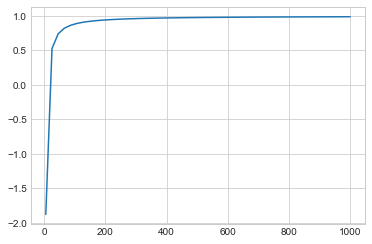

In [49]:
alpha = np.linspace(5, 1000)
epsilon_bar = 1 - np.log(1e5)/(alpha - 1)
plt.plot(alpha, epsilon_bar)
plt.show()

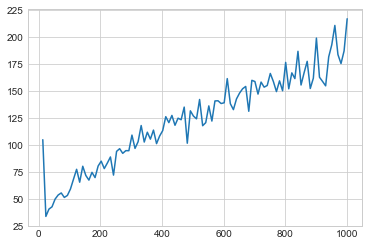

In [67]:
alphas = np.linspace(13, 1000, 100)
epsilon_bars = 1 - np.log(1e5)/(alphas - 1)
errors = [np.mean(
    [abs(r_a - l_a)
     for (r_a, l_a)
     in zip(real_answers, workload_gaussian_vec_RDP(random_workload, a, e))])
    for (a, e)
    in zip(alphas, epsilon_bars)]
plt.plot(alphas, errors)
plt.show()

It seems like the best value i can get for the accuracy with those parameters is about as good as regular epsilon-delta for this particular application